In [1]:
from download_dataset import download, extract

download()
extract('../data/notMNIST_large.tar.gz')

im_root = '../data/notMNIST_large'

../data/notMNIST_large.tar.gz
File already exists.
Extracted.


In [2]:
train_batch_size = 2048
val_batch_size = 128
num_workers = 8

num_epochs = 100

In [3]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from PIL import Image

import cv2
from tqdm import tqdm

from config import image_size, pixel_depth
from config import train_percentage, test_percentage

labels_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
labels = []
data = []

for class_dir_name in os.listdir(im_root):
    class_dir = os.path.join(im_root, class_dir_name)
    print(class_dir, len(os.listdir(class_dir)))
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
        if image is not None:
            data.append(image)
            labels.append(labels_dict[class_dir_name])
data = pd.DataFrame.from_dict({'image': data, 'label': labels})

../data/notMNIST_large/E 52912
../data/notMNIST_large/C 52912
../data/notMNIST_large/J 52911
../data/notMNIST_large/I 52912
../data/notMNIST_large/H 52912
../data/notMNIST_large/G 52912
../data/notMNIST_large/D 52912
../data/notMNIST_large/B 52912
../data/notMNIST_large/A 52912
../data/notMNIST_large/F 52912


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)
test, val = train_test_split(test, test_size=0.25)

In [5]:
from data_loader import MnistDataset
from torch.utils.data import DataLoader
from torchvision import transforms


tfms = transforms.Compose([transforms.ToTensor()])
train_dataset = MnistDataset(data, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

# val data
val_tfms = transforms.Compose([transforms.ToTensor()])
val_dataset = MnistDataset(val, transforms=val_tfms)
val_loader = DataLoader(val_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)


# test data
test_tfms = transforms.Compose([transforms.ToTensor()])
test_dataset = MnistDataset(test, transforms=test_tfms)
test_loader = DataLoader(test_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)

In [6]:
len(train_loader), len(val_loader), len(test_loader)

(259, 207, 621)

In [7]:
from torch.utils.tensorboard import SummaryWriter

# Лабораторная №3

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# hyperparameters

In [10]:
output_size = 10
learning_rate = 0.001

### Задание 1.
#### Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации. Какова точность построенное модели?

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),
            nn.Linear(512, 10),
        )
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
model = Net()
model.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)
logs_writer = SummaryWriter(log_dir='./logs/simple-cnn')

In [14]:
from train_loop import train

train(model, train_loader, val_loader, num_epochs, 
    optimizer, criterion, logs_writer, device)

100%|██████████| 100/100 [1:15:37<00:00, 45.37s/it]


In [15]:
from train_loop import calculate_accuracy

model.eval()

accuracy = calculate_accuracy(model, train_loader, device)
logs_writer.add_scalar('Accuracy/test', accuracy, 0)

### Задание 2.
#### Замените один из сверточных слоев на слой, реализующий операцию пулинга (Pooling) с функцией максимума или среднего. Как это повлияло на точность классификатора?


In [16]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3136, 512),
            nn.Linear(512, 10),
        )
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [17]:
model = Net()
model.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [18]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)
logs_writer = SummaryWriter(log_dir='./logs/simple-cnn-pool')

In [19]:
from train_loop import train

train(model, train_loader, val_loader, num_epochs, 
    optimizer, criterion, logs_writer, device)

100%|██████████| 100/100 [29:03<00:00, 17.44s/it]


In [20]:
from train_loop import calculate_accuracy

model.eval()

accuracy = calculate_accuracy(model, train_loader, device)
logs_writer.add_scalar('Accuracy/test', accuracy, 0)

### Задание 3.
#### Реализуйте классическую архитектуру сверточных сетей LeNet-5 (http://yann.lecun.com/exdb/lenet/).

In [21]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(400, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# net = Net()
model = Net()
model.cuda()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)
logs_writer = SummaryWriter(log_dir='./logs/lenet')

In [23]:
from train_loop import train

train(model, train_loader, val_loader, num_epochs, 
    optimizer, criterion, logs_writer, device)

100%|██████████| 100/100 [12:10<00:00,  7.30s/it]


In [24]:
from train_loop import calculate_accuracy

model.eval()

accuracy = calculate_accuracy(model, train_loader, device)
logs_writer.add_scalar('Accuracy/test', accuracy, 0)

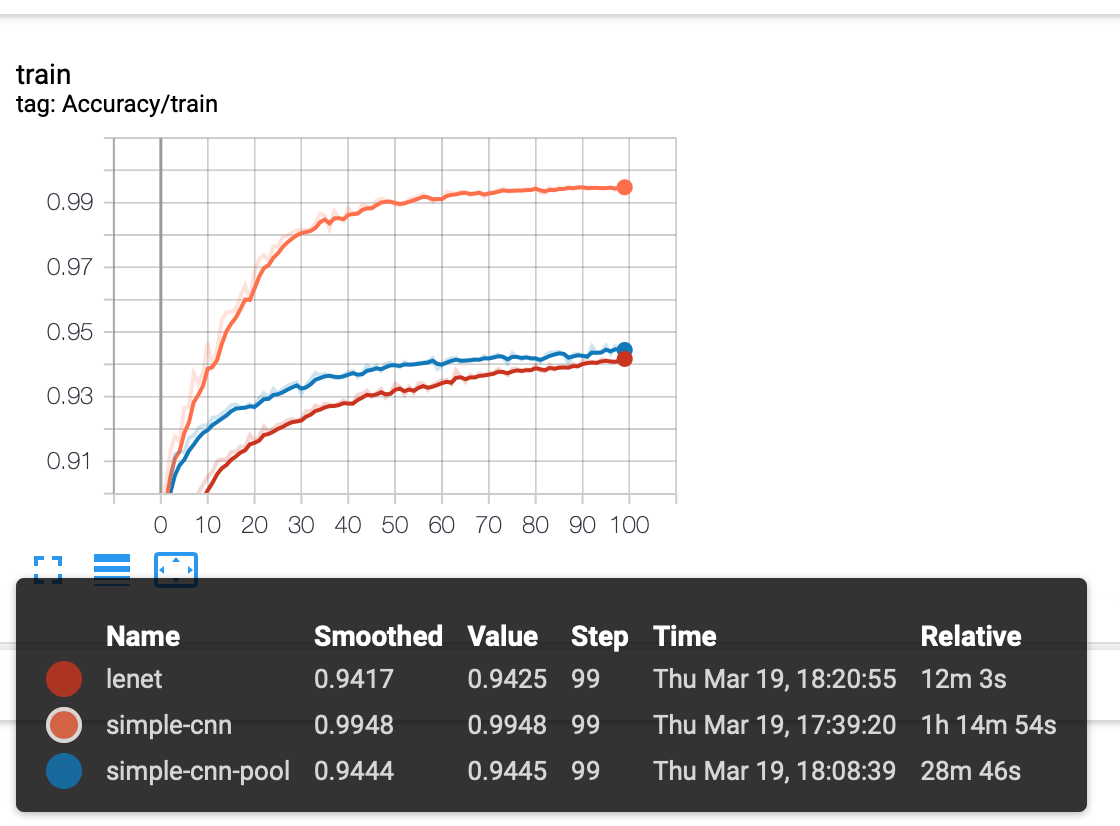

In [4]:
from IPython.display import Image
Image(filename='images/AccuracyVal.png') 

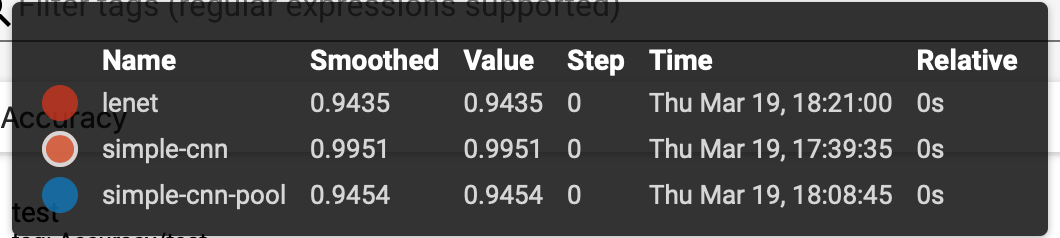

In [5]:
from IPython.display import Image
Image(filename='images/AccuracyTest.png') 